In [1]:
import os
import re
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import json
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, coo_matrix
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, GraphSAGE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import RandomNodeSplit
import torch_geometric.nn as pyg_nn

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["TORCH_USE_CUDA_DSA"] = "1"


In [2]:
def generate_graph_data(num_nodes=1000):
    np.random.seed(1127)
    torch.manual_seed(1127)
    
    # 비선형 데이터
    X = np.random.rand(num_nodes, 5)  # 5차원
    y = np.sin(X[:, 0] * 3) + 0.1 * np.random.rand(num_nodes)
    
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    
    # PyG 데이터 변환
    return Data(
        x = torch.tensor(X, dtype = torch.float32),
        edge_index= edge_index,
        y = torch.tensor(y, dtype = torch.float32).unsqueeze(1),
    )

def generate_noisy_graph_data(num_nodes=1000, noise_type="gaussian", noise_level=0.1, outlier_ratio=0.05):
    """
    다양한 노이즈를 추가하여 그래프 데이터를 생성하는 함수

    Args:
    - num_nodes (int): 노드 개수
    - noise_type (str): 추가할 노이즈 유형 ("gaussian", "uniform", "outlier", "edge_noise")
    - noise_level (float): 노이즈의 강도 (가우시안 및 유니폼 노이즈)
    - outlier_ratio (float): 이상치(outlier) 비율

    Returns:
    - PyG Data 객체
    """
    np.random.seed(1127)
    torch.manual_seed(1127)
    
    X = np.random.rand(num_nodes, 5)  # 5차원 특징
    y = np.sin(X[:, 0] * 3) + 0.1 * np.random.rand(num_nodes)  # 기본 타겟
    
    if noise_type == "gaussian":
        y += np.random.normal(0, noise_level, size=num_nodes)
    elif noise_type == "uniform":
        y += np.random.uniform(-noise_level, noise_level, size=num_nodes)
    elif noise_type == "outlier":
        num_outliers = int(num_nodes * outlier_ratio)
        outlier_indices = np.random.choice(num_nodes, num_outliers, replace=False)
        y[outlier_indices] += np.random.normal(3, 1.0, size=num_outliers)  # 극단적인 변화

    # 그래프 구조적 노이즈 (엣지 변경)
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    if noise_type == "edge_noise":
        # 엣지에 무작위 잡음을 추가하여 구조적 변형 수행
        num_noisy_edges = int(edge_index.shape[1] * noise_level)
        noise_indices = np.random.choice(edge_index.shape[1], num_noisy_edges, replace=False)
        edge_index[:, noise_indices] = torch.randint(0, num_nodes, (2, num_noisy_edges))

    return Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.float32).unsqueeze(1),
    )

def max_normalize(x):
    return x / np.max(np.abs(x)) if np.max(np.abs(x)) != 0 else x

def std_normalize(x):
    return (x - np.mean(x)) / np.std(x) if np.std(x) != 0 else np.zeros(len(x))

def int_normalize(x):
    return ((x - np.min(x)) / (np.max(x) - np.min(x)) * 2 - 1) if np.std(x) != 0 else np.zeros(len(x))

def simulate_ising(n, h0, J):
    G = nx.grid_2d_graph(n, n)
    l = np.linspace(-1.0, 1.0, n)
    
    s = np.random.choice([-1, 1], size=(n, n))
    # Placeholder for metropolis algorithm
    y = s.flatten()
    f = [[l[i], l[j]] for j in range(n) for i in range(n)]
    
    return G, [nx.to_scipy_sparse_matrix(G)], y, f

def parse_mean_fill(series, normalize=False):
    series = series.replace({',': ''}, regex=True)
    series = pd.to_numeric(series, errors='coerce')
    mean_val = series.mean()
    series.fillna(mean_val, inplace=True)
    
    if normalize:
        series = (series - mean_val) / series.std()
    
    return series.values

def read_county(prediction, year):
    adj = pd.read_csv("dataset/election/adjacency.txt", header=None, sep="\t", dtype=str, encoding="ISO-8859-1")
    fips2cty = {row[1]: row[0] for _, row in adj.iterrows() if pd.notna(row[1])}
    
    hh = adj.iloc[:, 1].ffill().astype(int)
    tt = adj.iloc[:, 3].astype(int)
    
    fips = sorted(set(hh).union(set(tt)))
    id2num = {id_: num for num, id_ in enumerate(fips)}
    
    G = nx.Graph()
    G.add_nodes_from(range(len(id2num)))
    G.add_edges_from([(id2num[h], id2num[t]) for h, t in zip(hh, tt)])
    
    # Load datasets
    VOT = pd.read_csv("dataset/election/election.csv")
    ICM = pd.read_csv("dataset/election/income.csv")
    POP = pd.read_csv("dataset/election/population.csv")
    EDU = pd.read_csv("dataset/election/education.csv")
    UEP = pd.read_csv("dataset/election/unemployment.csv")
    
    cty = pd.DataFrame({'FIPS': fips, 'County': [fips2cty.get(f, '') for f in fips]})
    vot = VOT[['fips_code', f'dem_{year}', f'gop_{year}']].rename(columns={'fips_code': 'FIPS'})
    icm = ICM[['FIPS', f'MedianIncome{min(max(2011, year), 2018)}']]
    pop = POP[['FIPS', f'R_NET_MIG_{min(max(2011, year), 2018)}', f'R_birth_{min(max(2011, year), 2018)}', f'R_death_{min(max(2011, year), 2018)}']]
    edu = EDU[['FIPS', f'BachelorRate{year}']]
    uep = UEP[['FIPS', f'Unemployment_rate_{min(max(2007, year), 2018)}']]
    
    dat = cty.merge(vot, on='FIPS', how='left')
    dat = dat.merge(icm, on='FIPS', how='left')
    dat = dat.merge(pop, on='FIPS', how='left')
    dat = dat.merge(edu, on='FIPS', how='left')
    dat = dat.merge(uep, on='FIPS', how='left')
    
    # Extract features and labels
    dem = parse_mean_fill(dat.iloc[:, 2])
    gop = parse_mean_fill(dat.iloc[:, 3])
    
    ff = np.zeros((len(dat), 7), dtype=np.float32)
    for i in range(6):
        ff[:, i] = parse_mean_fill(dat.iloc[:, i + 4], normalize=True)
    
    ff[:, 6] = (gop - dem) / (gop + dem)
    
    label_mapping = {
        "income": 0, "migration": 1, "birth": 2, "death": 3,
        "education": 4, "unemployment": 5, "election": 6
    }
    
    if prediction not in label_mapping:
        raise ValueError("Unexpected prediction type")
    
    pos = label_mapping[prediction]
    y = ff[:, pos]
    f = [np.concatenate((ff[i, :pos], ff[i, pos + 1:])) for i in range(len(dat))]
    
    return G, [csr_matrix(nx.adjacency_matrix(G))], y, f

def load_county_graph_data(prediction: str, year: int):
    G, A, labels, feats = read_county(prediction, year)

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def read_transportation_network(network_name, net_skips, net_cols, netf_cols, flow_skips, flow_cols, V_range):
    # Load data
    dat_net = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_net.tntp", 
                           skiprows=net_skips, sep='\s+', usecols=net_cols, header=None).values
    dat_netf = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_net.tntp", 
                            skiprows=net_skips, sep='\s+', usecols=netf_cols, header=None).values
    dat_flow = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_flow.tntp", 
                            skiprows=flow_skips, sep='\s+', usecols=flow_cols, header=None).values
    
    # Map node labels to indices
    lb2id = {v: i for i, v in enumerate(V_range, start=1)}
    NV = len(V_range)
    
    # Create directed graph
    g = nx.DiGraph()
    g.add_nodes_from(range(1, NV + 1))
    
    for src, dst in dat_net:
        if src in lb2id and dst in lb2id:
            g.add_edge(lb2id[src], lb2id[dst])
    
    # Edge labels
    flow_dict = {}
    for src, dst, flow in dat_flow:
        if src in lb2id and dst in lb2id:
            flow_dict[(lb2id[src], lb2id[dst])] = flow
    
    y = np.array([flow_dict.get((e[0], e[1]), 0) for e in g.edges()])
    y = (y - np.mean(y)) / np.std(y)  # Standard normalization
    
    # Edge features
    netf_dict = {}
    for i in range(len(dat_net)):
        src, dst = dat_net[i]
        if src in lb2id and dst in lb2id:
            netf_dict[(lb2id[src], lb2id[dst])] = dat_netf[i]
    
    ff = np.array([netf_dict[e] for e in g.edges()])
    mean_ff = np.mean(ff, axis=0)
    std_ff = np.std(ff, axis=0)
    std_ff[std_ff == 0] = 1  # Prevent division by zero
    netf = (ff - mean_ff) / std_ff  
    
    f = list(netf)
    
    # Line graph transformation
    G1 = nx.Graph()
    G2 = nx.Graph()
    sorted_edges = sorted(g.edges())
    tuple2id = {e: i for i, e in enumerate(sorted_edges)}
    
    for u in g.nodes:
        innbrs = list(g.predecessors(u))
        outnbrs = list(g.successors(u))
        
        for v in innbrs:
            for w in outnbrs:
                if (v, u) in tuple2id and (u, w) in tuple2id:
                    G1.add_edge(tuple2id[(v, u)], tuple2id[(u, w)])
        
        for v in innbrs:
            for w in innbrs:
                if w > v and (v, u) in tuple2id and (w, u) in tuple2id:
                    G2.add_edge(tuple2id[(v, u)], tuple2id[(w, u)])
        
        for v in outnbrs:
            for w in outnbrs:
                if w > v and (u, v) in tuple2id and (u, w) in tuple2id:
                    G2.add_edge(tuple2id[(u, v)], tuple2id[(u, w)])
                    
    size = max(len(G1.nodes), len(G2.nodes))
    A1 = np.zeros((size, size))
    A2 = np.zeros((size, size))
    
    A1[:nx.number_of_nodes(G1), :nx.number_of_nodes(G1)] = nx.adjacency_matrix(G1).todense()
    A2[:nx.number_of_nodes(G2), :nx.number_of_nodes(G2)] = nx.adjacency_matrix(G2).todense()
    
    A = A1 + A2
    
    return nx.Graph(A), A, y, f

def load_trans_graph_data(city: str):
    if city == 'Anaheim':
        G, A, labels, feats = read_transportation_network(city, 8, [0, 1], [2, 3, 4, 7], 6, [0, 1, 3], range(1, 417))
    elif city == 'ChicagoSketch':
        G, A, labels, feats = read_transportation_network(city, 7, [0, 1], [2, 3, 4, 7], 1, [0, 1, 2], range(388, 934))

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def read_twitch_network(cnm, dim_reduction=False, dim_embed=8):
    feats_all = []
    countries = ["DE", "ENGB", "ES", "FR", "PTBR", "RU"]
    
    for cn in countries:
        with open(f"dataset/twitch/{cn}/musae_{cn}_features.json", "r") as f:
            feats = json.load(f)
        feats_all.extend(feats.values())

    ndim = max(np.concatenate(feats_all)) + 1

    def feat_encode(feat_list):
        """특징 벡터를 원핫 인코딩 형태로 변환"""
        vv = np.zeros(ndim, dtype=np.float32)
        valid_indices = np.array(feat_list)
        
        if np.any(valid_indices >= ndim):
            raise ValueError(f"Index out of bounds! Max index: {max(valid_indices)}, ndim: {ndim}")
        
        vv[valid_indices] = 1.0
        return vv

    f_all = list(map(feat_encode, feats_all))

    with open(f"dataset/twitch/{cnm}/musae_{cnm}_features.json", "r") as f:
        feats = json.load(f)

    id2ft = {int(k) + 1: v for k, v in feats.items()}
    n = len(id2ft)
    assert min(id2ft.keys()) == 1 and max(id2ft.keys()) == n

    f = [feat_encode(id2ft[i]) for i in sorted(id2ft.keys())]

    if dim_reduction:
        f_matrix = np.stack(f_all, axis=1)
        U, S, Vt = svds(f_matrix, k=dim_embed)
        U *= np.sign(np.sum(U, axis=0))  # sign correction
        f = [U.T @ f_ for f_ in f]

    g = nx.Graph()
    g.add_nodes_from(range(1, len(f) + 1))

    links = pd.read_csv(f"dataset/twitch/{cnm}/musae_{cnm}_edges.csv")
    for _, row in links.iterrows():
        g.add_edge(row["from"] + 1, row["to"] + 1)

    trgts = pd.read_csv(f"dataset/twitch/{cnm}/musae_{cnm}_target.csv")
    nid2views = dict(zip(trgts["new_id"], trgts["views"]))
    y = std_normalize(np.log([nid2views[i - 1] + 1.0 for i in range(1, g.number_of_nodes() + 1)]))

    return g, [csr_matrix(nx.adjacency_matrix(g))], y, f

def load_twitch_graph_data(cnm: str):
    G, A, labels, feats = read_twitch_network(cnm)

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def load_wiki_graph_data(category):
    edge_path = f'dataset/wikipedia/{category}/musae_{category}_edges.csv'
    feature_path = f'dataset/wikipedia/{category}/musae_{category}_features.json'
    target_path = f'dataset/wikipedia/{category}/musae_{category}_target.csv'
    
    # 엣지 데이터 로드
    edge_df = pd.read_csv(edge_path)
    edge_index = torch.tensor(edge_df.values.T, dtype=torch.long)
    
    # 피처 데이터 로드
    with open(feature_path, "r") as f:
        features_dict = json.load(f)
    
    node_ids = sorted(map(int, features_dict.keys()))  # 노드 ID 정렬
    node_id_map = {old_id: new_id for new_id, old_id in enumerate(node_ids)}
    
    num_nodes = len(node_ids)
    num_features = max(max(v) for v in features_dict.values()) + 1  # 가장 큰 feature index 찾기
    x = torch.zeros((num_nodes, num_features), dtype=torch.float32)
    
    for node, features in features_dict.items():
        new_id = node_id_map[int(node)]  # 노드 ID 변환
        x[new_id, features] = 1.0  # One-hot 인코딩
    
    # 타겟 데이터 로드
    target_df = pd.read_csv(target_path)
    target_df["id"] = target_df["id"].map(node_id_map)  # 노드 ID 변환
    target_df = target_df.dropna().astype(int)  # 변환되지 않은 노드 제거
    
    # y = torch.zeros(num_nodes, dtype=torch.long)
    y = torch.zeros((num_nodes, 1), dtype=torch.long)  # [, 1] 형태로 변경
    y[target_df["id"].values] = torch.tensor(target_df["target"].values, dtype=torch.long).view(-1, 1)
    
    # PyG Data 객체 생성
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    return graph_data

def set_seed(seed=1127):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def to_numpy(tensor):
    """PyTorch Tensor → NumPy 변환 후 1차원으로 변형"""
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy().squeeze()
    elif isinstance(tensor, np.ndarray):
        return tensor.squeeze()
    else:
        raise TypeError(f"Unsupported data type: {type(tensor)}")
 
def sort_by_y(x, y, *intervals):
    sort_idx = np.argsort(to_numpy(y).ravel())  # Y값을 기준으로 정렬할 인덱스
    sorted_x = to_numpy(x).ravel()[sort_idx]
    sorted_y = to_numpy(y).ravel()[sort_idx]
    sorted_intervals = [to_numpy(interval).ravel()[sort_idx] for interval in intervals]
    return sorted_x, sorted_y, sorted_intervals

def split_graph_data(graph_data, test_ratio=0.2):
    """
    GNN용 Train-Test Split (edge_index를 올바르게 재매핑하여 유지)
    """
    num_nodes = graph_data.x.shape[0]  # 전체 노드 개수
    num_test = int(num_nodes * test_ratio)  # 테스트 데이터 노드 개수

    # 랜덤하게 Train/Test 노드 인덱스 선택
    indices = torch.randperm(num_nodes)
    test_nodes = indices[:num_test]
    train_nodes = indices[num_test:]

    # 노드 마스크 생성
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_nodes] = True
    test_mask[test_nodes] = True

    # Train/Test용 edge_index 필터링
    train_edge_mask = train_mask[graph_data.edge_index[0]] & train_mask[graph_data.edge_index[1]]
    test_edge_mask = test_mask[graph_data.edge_index[0]] & test_mask[graph_data.edge_index[1]]

    # Train용 edge_index와 노드 인덱스 재매핑
    train_edge_index = graph_data.edge_index[:, train_edge_mask]
    train_node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(train_nodes)}
    train_edge_index = torch.tensor(
        [[train_node_map[idx.item()] for idx in train_edge_index[0]],
         [train_node_map[idx.item()] for idx in train_edge_index[1]]],
        dtype=torch.long
    )

    # Test용 edge_index와 노드 인덱스 재매핑
    test_edge_index = graph_data.edge_index[:, test_edge_mask]
    test_node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(test_nodes)}
    test_edge_index = torch.tensor(
        [[test_node_map[idx.item()] for idx in test_edge_index[0]],
         [test_node_map[idx.item()] for idx in test_edge_index[1]]],
        dtype=torch.long
    )

    # Train 데이터 생성
    train_data = Data(
        x=graph_data.x[train_mask],
        y=graph_data.y[train_mask],
        edge_index=train_edge_index
    )

    # Test 데이터 생성
    test_data = Data(
        x=graph_data.x[test_mask],
        y=graph_data.y[test_mask],
        edge_index=test_edge_index
    )

    # 결과 출력
    print(f"Train Nodes: {train_data.x.shape[0]}, Train Edges: {train_data.edge_index.shape[1]}")
    print(f"Train edge_index 최대값: {train_data.edge_index.max().item()}")
    print(f"Test Nodes: {test_data.x.shape[0]}, Test Edges: {test_data.edge_index.shape[1]}")
    print(f"Test edge_index 최대값: {test_data.edge_index.max().item()}")

    return train_data, test_data

# def split_graph_data(graph_data, test_ratio=0.2):
#     transform = RandomNodeSplit(split="train_rest", num_val=0.0, num_test=test_ratio)
#     data = transform(graph_data)

#     # Train/Test 마스크 생성
#     train_mask = data.train_mask.to(data.x.device)
#     test_mask = data.test_mask.to(data.x.device)

#     # 훈련 및 테스트 데이터 선택
#     train_data = data.clone()
#     test_data = data.clone()

#     train_data.x = data.x[train_mask]
#     train_data.y = data.y[train_mask]
#     test_data.x = data.x[test_mask]
#     test_data.y = data.y[test_mask]

#     # 노드 인덱스를 매핑하여 edge_index 수정 (훈련 데이터)
#     train_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(train_mask.nonzero(as_tuple=True)[0])}
#     train_edges_mask = train_mask[data.edge_index[0]] & train_mask[data.edge_index[1]]
#     train_edges = data.edge_index[:, train_edges_mask]

#     train_data.edge_index = torch.stack([
#         torch.tensor([train_node_mapping[i.item()] for i in train_edges[0]], dtype=torch.long, device=data.x.device),
#         torch.tensor([train_node_mapping[i.item()] for i in train_edges[1]], dtype=torch.long, device=data.x.device)
#     ], dim=0)

#     # 노드 인덱스를 매핑하여 edge_index 수정 (테스트 데이터)
#     test_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(test_mask.nonzero(as_tuple=True)[0])}
#     test_edges_mask = test_mask[data.edge_index[0]] & test_mask[data.edge_index[1]]
#     test_edges = data.edge_index[:, test_edges_mask]

#     test_data.edge_index = torch.stack([
#         torch.tensor([test_node_mapping[i.item()] for i in test_edges[0]], dtype=torch.long, device=data.x.device),
#         torch.tensor([test_node_mapping[i.item()] for i in test_edges[1]], dtype=torch.long, device=data.x.device)
#     ], dim=0)

#     print(f"Train data: {train_data.x.shape[0]} nodes, {train_data.edge_index.shape[1]} edges")
#     print(f"Test data: {test_data.x.shape[0]} nodes, {test_data.edge_index.shape[1]} edges")
    
#     return train_data, test_data

def augment_features(x, tau):
    if isinstance(tau, float):  # tau가 float이면 변환
        tau = torch.tensor([tau])
    
    tau = tau.view(-1, 1)
    tau_transformed = (tau - 0.5) * 12 # 분위수 값 변환: 학습 안정성 증가
    
    return torch.cat((x, tau_transformed.expand(x.size(0), -1)), dim = 1)

def coverage_width(y_true, y_low, y_upper):
    coverage = ((y_true >= y_low) & (y_true <= y_upper)).float().mean()
    width = (y_upper - y_low).float().abs().mean()
    
    return coverage, width
    
def evaluate_model_performance(preds_low, preds_upper, targets, target=0.9):
    coverage = np.mean((targets >= preds_low) & (targets <= preds_upper))
    
    interval_width = np.mean(preds_upper - preds_low)
    normalized_interval_width = interval_width / (np.max(targets) - np.min(targets))
    
    median_pred = (preds_low + preds_upper) / 2    # 신뢰구간 중앙값
    mpe = np.mean(np.abs(median_pred - targets)) # 예측 구간 중심이 실제값과 얼마나 가까운지
    
    sharpness = np.mean(np.square(preds_upper - preds_low)) # 예측 구간의 날카로움: 제곱을 사용해 큰 폭일수록 더 강한 패널티
    
    alpha = 0.5
    penalties = np.where(targets < preds_low, preds_low - targets, np.where(targets > preds_upper, targets - preds_upper, 0))  
    winkler = np.mean(interval_width + 2 * alpha * penalties) # 신뢰구간이 실제값을 포함하지 않으면 패널티 적용
    
    MCT = interval_width * abs(coverage - target)     # 조정된 Coverage Tradeoff 지표 (MCT)

    print(f"예측 관련 - Coverage Rate (CR) ⬆: {coverage:.2f}, Mean Prediction Error (MPE) ⬇: {mpe:.2f}")
    print(f"구간 관련 - Interval Width (IW) ⬇: {interval_width:.2f}, Sharpness ⬇: {sharpness:.2f}, Winkler Score (WS) ⬇: {winkler:.2f}")
    print(f"종합 - MisCoverage Trade-off (MCT) ⬇: {MCT:.2f}")
    
    # return {
    #     "Coverage Rate (CR)": coverage,
    #     "Interval Width (IW)": interval_width,
    #     "Normalized IW": normalized_interval_width,
    #     "Mean Prediction Error (MPE)": mpe,
    #     "Sharpness": sharpness,
    #     "Winkler Score (WS)": winkler,
    #     "MisCoverage Trade-off (MCT)": MCT
    # }

set_seed(1127)  

In [34]:
class GQNN_R(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim+1, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, edge_index, tau):
        x = augment_features(x, tau)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        return self.fc(x)
    
class GQNN_N(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 2)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        return self.fc(x)
    
class GNN_CP(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        return self.fc(x)
    
class QRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y_true, tau):
        diff = y_true - y_pred
        loss = torch.where(diff > 0, tau * diff, (tau - 1) * diff)
        
        return torch.mean(loss)
    
class RQRLoss(nn.Module):
    def __init__(self, target=0.9, lambda_factor=1.0, order_penalty=1.0):
        super().__init__()
        self.target = target
        self.lf = lambda_factor
        self.order_penalty = order_penalty
    
    def forward(self, preds, target):
        q1, q2 = preds[:, 0], preds[:, 1]
        diff1 = target - q1
        diff2 = target - q2
        width = q2 - q1
        
        rqr_loss = torch.maximum(diff1 * diff2 * (self.target + 2 * self.lf),
                                diff2 * diff1 * (self.target + 2 * self.lf - 1))
        
        width_loss = self.lf * torch.square(width) * 0.5
        
        # 추가 손실항
        order_penalty_term = self.order_penalty * torch.relu(q1 - q2)
        
        return torch.mean(rqr_loss + width_loss + order_penalty_term)
    
class IQRLoss(nn.Module):
    def __init__(self, target_coverage=0.9, gamma_factor=2, lambda_factor=1):
        super().__init__()
        self.alpha = target_coverage
        self.gf = gamma_factor
        self.lf = lambda_factor
        
    def forward(self, preds_low, preds_upper, tau_low, tau_upper, target):
        # Quantile Loss
        diff1 = target - preds_low
        loss1 = torch.where(diff1 > 0, tau_low * diff1, (tau_low - 1) * diff1)
        # 하한 손실에 1.5배 가중치: 하한 예측 더 신중하게 학습하도록
        # loss1 = torch.where(diff1 > 0, 1.5 * tau_low * diff1, 1.5 * (tau_low - 1) * diff1) 
        diff2 = target - preds_upper
        loss2 = torch.where(diff2 > 0, tau_upper * diff2, (tau_upper - 1) * diff2)
        qr_loss = torch.mean(loss1 + loss2)
        
        # Coverage Loss
        coverage_loss = torch.mean(torch.maximum(diff1 * diff2 * (self.alpha + 2 * self.lf), 
                                                 diff2 * diff1 * (self.alpha + 2 * self.lf - 1)) )
        # in_coverage = (preds_low <= target) & (target <= preds_upper)  # 구간 내 포함 여부
        # current_coverage = torch.mean(in_coverage.float())  # 현재 커버리지 비율
        # coverage_loss = torch.mean(self.gf * torch.square(self.alpha - current_coverage) * 0.5)
        
        # Width loss
        # width_penalty = torch.mean(self.lf * torch.square(preds_upper - preds_low) * 0.5)
        # violation_penalty = torch.relu(preds_low - preds_upper).mean() * 10
        
        loss = qr_loss + coverage_loss 
        # + width_penalty
    
        return loss

class IQRLossWithCoverage(nn.Module):
    def __init__(self, target_coverage=0.9, coverage_weight=1.0):
        super().__init__()
        self.target_coverage = target_coverage  # 목표 커버리지 (예: 0.9 for 90%)
        self.coverage_weight = coverage_weight  # 커버리지 손실 가중치
        
    def forward(self, preds_low, preds_upper, target, tau_low, tau_upper):
        # 기존 Quantile Loss 계산
        diff1 = target - preds_low
        diff2 = target - preds_upper
        loss1 = torch.where(diff1 > 0, tau_low * diff1, (tau_low - 1) * diff1)
        loss2 = torch.where(diff2 > 0, tau_upper * diff2, (tau_upper - 1) * diff2)
        quantile_loss = torch.mean(loss1 + loss2)
        
        # 커버리지 계산
        in_coverage = (preds_low <= target) & (target <= preds_upper)  # 구간 내 포함 여부
        actual_coverage = torch.mean(in_coverage.float())  # 실제 커버리지 비율
        
        # 커버리지 손실: 목표 커버리지와의 차이를 벌점으로 추가
        coverage_loss = torch.abs(self.target_coverage - actual_coverage)
        
        # 총 손실: Quantile Loss + Coverage Loss
        total_loss = quantile_loss + self.coverage_weight * coverage_loss
        
        return total_loss


In [4]:
class BayesianLinear(nn.Module):
    """Bayesian Linear Layer"""
    def __init__(self, in_features, out_features, prior_std=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Mean and log variance of weights
        self.w_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.w_logvar = nn.Parameter(torch.zeros(out_features, in_features))

        # Mean and log variance of biases
        self.b_mu = nn.Parameter(torch.zeros(out_features))
        self.b_logvar = nn.Parameter(torch.zeros(out_features))

        # Prior distribution (Gaussian)
        self.prior = Normal(0, prior_std)

    def forward(self, x):
        # Sample weights and biases
        w_std = torch.exp(0.5 * self.w_logvar)
        b_std = torch.exp(0.5 * self.b_logvar)

        w = self.w_mu + w_std * torch.randn_like(w_std)
        b = self.b_mu + b_std * torch.randn_like(b_std)

        return F.linear(x, w, b)

class BayesianGNN(nn.Module):
    """Bayesian GNN using Bayesian Linear Layer"""
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = BayesianLinear(hidden_dim, 1)  # Bayesian Linear Layer

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.fc(x).squeeze()  # (batch_size,)
    
class MCDropoutGNN(nn.Module):
    """MC Dropout 기반 GNN"""
    def __init__(self, in_dim, hidden_dim, dropout=0.2):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index, training=True):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=training)  # Dropout 유지
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=training)  # Dropout 유지
        return self.fc(x).squeeze()  # (batch_size,)


In [5]:
# 기본 비선형 그래프 데이터
graph_data_basic = generate_graph_data(num_nodes=1000)

# 노이즈 비선형 그래프 데이터
graph_data_noise_gaussian = generate_noisy_graph_data(num_nodes=1000, noise_type='gaussian', noise_level=0.3)
graph_data_noise_uniform = generate_noisy_graph_data(num_nodes=1000, noise_type='uniform', noise_level=0.3)
graph_data_noise_outlier = generate_noisy_graph_data(num_nodes=1000, noise_type='outlier', noise_level=0.3)
graph_data_noise_edge = generate_noisy_graph_data(num_nodes=1000, noise_type='edge_noise', noise_level=0.3)

# County 데이터셋
graph_data_county_edu = load_county_graph_data('education', 2012)
graph_data_county_elec = load_county_graph_data('election', 2012)
graph_data_county_inc = load_county_graph_data('income', 2012)
graph_data_county_unemp = load_county_graph_data('unemployment', 2012)

# Twitch 데이터셋
# graph_data_twitch_de = load_twitch_graph_data('DE')
# graph_data_twitch_engb = load_twitch_graph_data('ENGB')
# graph_data_twitch_es = load_twitch_graph_data('ES')
# graph_data_twitch_fr = load_twitch_graph_data('FR')
graph_data_twitch_ptbr = load_twitch_graph_data('PTBR')
# graph_data_twitch_ru = load_twitch_graph_data('RU')

# Wikipedia 데이터
graph_data_wiki_ch = load_wiki_graph_data('chameleon')
graph_data_wiki_cr = load_wiki_graph_data('crocodile')
graph_data_wiki_sq = load_wiki_graph_data('squirrel')

# Transfortation 데이터셋
graph_data_trans_ana = load_trans_graph_data('Anaheim')
graph_data_trans_chica = load_trans_graph_data('ChicagoSketch')

/tmp/ipykernel_1521236/1017196909.py:162: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  pyg_data.x = torch.tensor(feats, dtype=torch.float)


In [6]:
# 데이터 분리
train_data, test_data = split_graph_data(graph_data_basic)

Train Nodes: 800, Train Edges: 1287
Train edge_index 최대값: 799
Test Nodes: 200, Test Edges: 87
Test edge_index 최대값: 198


In [7]:
# Train 데이터에서 min/max 구하기
train_min = train_data.x.min()
train_max = train_data.x.max()
y_min = train_data.y.min()
y_max = train_data.y.max()

# 정규화 함수
def normalize(tensor, min_val, max_val):
    return (tensor - min_val) / (max_val - min_val)

train_data.x = normalize(train_data.x, train_min, train_max)
test_data.x = normalize(test_data.x, train_min, train_max)
train_data.y = normalize(train_data.y, y_min, y_max)
test_data.y = normalize(test_data.y, y_min, y_max)

print('-' * 20, 'Calibration Dataset', '-' * 20)
cp_train_data, calibration_data = split_graph_data(train_data)
num_train = train_data.x.shape[0]
num_calibration = int(num_train * 0.2)  # Calibration 비율 20%

# 랜덤하게 인덱스 생성
indices = torch.randperm(num_train)
calibration_indices = indices[:num_calibration]
cp_train_indices = indices[num_calibration:]

# 노드 마스크 생성
cp_train_mask = torch.zeros(num_train, dtype=torch.bool)
calibration_mask = torch.zeros(num_train, dtype=torch.bool)
cp_train_mask[cp_train_indices] = True
calibration_mask[calibration_indices] = True

# cp_train용 edge_index 필터링 및 재매핑
cp_train_edge_mask = cp_train_mask[train_data.edge_index[0]] & cp_train_mask[train_data.edge_index[1]]
cp_train_edge_index = train_data.edge_index[:, cp_train_edge_mask]
cp_train_node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(cp_train_indices)}
cp_train_edge_index = torch.tensor(
    [[cp_train_node_map[idx.item()] for idx in cp_train_edge_index[0]],
     [cp_train_node_map[idx.item()] for idx in cp_train_edge_index[1]]],
    dtype=torch.long
)

# calibration용 edge_index 필터링 및 재매핑
calibration_edge_mask = calibration_mask[train_data.edge_index[0]] & calibration_mask[train_data.edge_index[1]]
calibration_edge_index = train_data.edge_index[:, calibration_edge_mask]
calibration_node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(calibration_indices)}
calibration_edge_index = torch.tensor(
    [[calibration_node_map[idx.item()] for idx in calibration_edge_index[0]],
     [calibration_node_map[idx.item()] for idx in calibration_edge_index[1]]],
    dtype=torch.long
)

# cp_train_data 생성
cp_train_data = Data(
    x=train_data.x[cp_train_indices],
    y=train_data.y[cp_train_indices],
    edge_index=cp_train_edge_index
)

# calibration_data 생성
calibration_data = Data(
    x=train_data.x[calibration_indices],
    y=train_data.y[calibration_indices],
    edge_index=calibration_edge_index
)

# 결과 출력
print(f"Train data: {cp_train_data.x.shape[0]} nodes, {cp_train_data.edge_index.shape[1]} edges")
print(f"Train edge_index 최대값: {cp_train_data.edge_index.max().item()}")
print(f"Calibration data: {calibration_data.x.shape[0]} nodes, {calibration_data.edge_index.shape[1]} edges")
print(f"Calibration edge_index 최대값: {calibration_data.edge_index.max().item()}")
print(f"Test data: {test_data.x.shape[0]} nodes, {test_data.edge_index.shape[1]} edges")
print(f"Test edge_index 최대값: {test_data.edge_index.max().item()}")

color = sns.color_palette("colorblind")

-------------------- Calibration Dataset --------------------
Train Nodes: 640, Train Edges: 836
Train edge_index 최대값: 639
Test Nodes: 160, Test Edges: 55
Test edge_index 최대값: 156
Train data: 640 nodes, 844 edges
Train edge_index 최대값: 639
Calibration data: 160 nodes, 52 edges
Calibration edge_index 최대값: 159
Test data: 200 nodes, 87 edges
Test edge_index 최대값: 198


In [ ]:
# SQR-GNN
in_dim = train_data.x.shape[1]
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
tau_low = 0.05
tau_upper = 0.95
gpu_number = 0

device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)

model = GQNN_R(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
criterion = QRLoss()

epochs = []
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    taus = torch.rand(train_data.x.size(0), 1, dtype=torch.float32, device=device)
    preds = model(train_data.x, train_data.edge_index, taus)
    loss = criterion(preds, train_data.y, taus)
        
    loss.backward()
    optimizer.step()
    
    epochs.append(epoch+1)
    losses.append(loss.item())
    
    # print(f"Epoch {epoch}: Quantile Loss = {loss.item():.4f}")

plt.figure(figsize=(5, 2))
plt.plot(epochs, losses, color=color[0])
plt.title('SQR-GNN Loss', size=10)
plt.show()

model.eval()
test_data = test_data.to(device)

tau_lows = torch.full((train_data.x.size(0), 1), tau_low, dtype=torch.float32, device=device)
tau_uppers = torch.full((train_data.x.size(0), 1), tau_upper, dtype=torch.float32, device=device)

with torch.no_grad():
    train_low_preds = model(train_data.x, train_data.edge_index, tau_lows).cpu().numpy()
    train_upper_preds = model(train_data.x, train_data.edge_index, tau_uppers).cpu().numpy()
    train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('Dark2')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('SQR-GNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[0], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[0], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

tau_lows = torch.full((test_data.x.size(0), 1), tau_low, dtype=torch.float32, device=device)
tau_uppers = torch.full((test_data.x.size(0), 1), tau_upper, dtype=torch.float32, device=device)

with torch.no_grad():
    test_low_preds = model(test_data.x, test_data.edge_index, tau_lows).cpu().numpy()
    test_upper_preds = model(test_data.x, test_data.edge_index, tau_uppers).cpu().numpy()
    test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('SQR-GNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[1], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[1], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

In [ ]:
# RQR-GNN
in_dim = train_data.x.shape[1]
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
target=0.9
lambda_factor=1.0
gpu_number = 0

device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)

model = GQNN_N(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
criterion = RQRLoss(target=target, lambda_factor=lambda_factor)

epochs = []
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    preds = model(train_data.x, train_data.edge_index)
    loss = criterion(preds, train_data.y)
        
    loss.backward()
    optimizer.step()
    
    epochs.append(epoch+1)
    losses.append(loss.item())
    
    # print(f"Epoch {epoch}: Quantile Loss = {loss.item():.4f}")
    
plt.figure(figsize=(5, 2))
plt.plot(epochs, losses, color=color[1])
plt.title('RQR-GNN Loss', size=10)
plt.show()

model.eval()
test_data = test_data.to(device)

with torch.no_grad():
    train_preds = model(train_data.x, train_data.edge_index)
    train_low_preds = train_preds[:, 0].cpu().numpy()
    train_upper_preds = train_preds[:, 1].cpu().numpy()
    train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('Dark2')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('RQR-GNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[2], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[2], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

with torch.no_grad():
    test_preds = model(test_data.x, test_data.edge_index)
    test_low_preds = test_preds[:, 0].cpu().numpy()
    test_upper_preds = test_preds[:, 1].cpu().numpy()
    test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)

x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('RQR-GNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[3], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[3], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

In [ ]:
# CP-GNN
in_dim = train_data.x.shape[1]
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
alpha = 0.1  # 신뢰수준 (1 - alpha)
gpu_number = 0

device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
# device =torch.device("cuda")
cp_train_data = cp_train_data.to(device)

model = GNN_CP(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)

epochs = []
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    preds = model(cp_train_data.x, cp_train_data.edge_index)
    loss = F.mse_loss(preds, cp_train_data.y)
    
    loss.backward()
    optimizer.step()
    epochs.append(epoch+1)
    losses.append(loss.item())

plt.figure(figsize=(5, 2))
plt.plot(epochs, losses, color =color[2])
plt.title('CP-GNN Loss', size=10)
plt.show()

model.eval()
calibration_data = calibration_data.to(device)
test_data = test_data.to(device)

with torch.no_grad():
    preds_cal = model(calibration_data.x, calibration_data.edge_index)
    preds_train = model(train_data.x, train_data.edge_index).cpu().numpy()
    preds_test = model(test_data.x, test_data.edge_index).cpu().numpy()

conformal_scores = torch.abs(calibration_data.y- preds_cal).cpu().numpy()
q_hat = np.quantile(conformal_scores, 1 - alpha)

train_low_preds = preds_train - q_hat
train_upper_preds = preds_train + q_hat
train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('Dark2')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('CP-GNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[6], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[6], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

test_low_preds = preds_test - q_hat
test_upper_preds = preds_test + q_hat
test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('CP-GNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[7], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[7], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

In [ ]:
# BNN
in_dim = train_data.x.shape[1]
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
num_samples=100
gpu_number = 0

device = torch.device("cuda:{gpu_number}" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)

model_bnn = BayesianGNN(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model_bnn.parameters(), lr=learning_rate, weight_decay=weight)

epochs = []
losses = []
for epoch in tqdm(range(num_epochs)):
    model_bnn.train()
    optimizer.zero_grad()
    
    preds = model_bnn(train_data.x, train_data.edge_index)
    loss = F.mse_loss(preds, train_data.y.squeeze())
    
    loss.backward()
    optimizer.step()

    epochs.append(epoch+1)
    losses.append(loss.item())
    
plt.figure(figsize=(5, 2))
plt.plot(epochs, losses, color =color[4])
plt.title('BayesianNN Loss', size=10)
plt.show()

model_bnn.eval()
test_data = test_data.to(device)

preds_list = []
with torch.no_grad():
    for _ in range(num_samples):
        preds = model_bnn(train_data.x, train_data.edge_index)  # Bayesian Sampling
        preds_list.append(preds.cpu().numpy())

preds_array = np.array(preds_list)  # (num_samples, num_nodes)
mean_preds = preds_array.mean(axis=0)  # 평균 예측값
std_preds = preds_array.std(axis=0)    # 표준편차

# 80%: 1.28
# 90%: 1.645
# 95%: 1.96
# 99%: 2.576
train_low_preds = mean_preds - 1.645 * std_preds  
train_upper_preds = mean_preds + 1.645 * std_preds 
train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('muted')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('BayesainNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[-1], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[-1], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

preds_list = []
with torch.no_grad():
    for _ in range(num_samples):
        preds = model_bnn(test_data.x, test_data.edge_index)  # Bayesian Sampling
        preds_list.append(preds.cpu().numpy())

preds_array = np.array(preds_list)  # (num_samples, num_nodes)
mean_preds = preds_array.mean(axis=0)  # 평균 예측값
std_preds = preds_array.std(axis=0)    # 표준편차

test_low_preds = mean_preds - 1.96 * std_preds  # 95% 신뢰구간 하한
test_upper_preds = mean_preds + 1.96 * std_preds  # 95% 신뢰구간 상한
test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)

x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('BayesianNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[-2], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[-2], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

In [ ]:
# MC Dropout
in_dim = train_data.x.shape[1]
hidden_dim = 64
dropout = 0.2
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
gpu_number = 0

device = torch.device("cuda:{gpu_number}" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)

model_mc = MCDropoutGNN(in_dim=in_dim, hidden_dim=hidden_dim, dropout=dropout).to(device)
optimizer = optim.Adam(model_mc.parameters(), lr=learning_rate, weight_decay=weight)

epochs = []
losses = []
for epoch in tqdm(range(num_epochs)):
    model_mc.train()
    optimizer.zero_grad()
    
    preds_mc = model_mc(train_data.x, train_data.edge_index, training=True)
    loss_mc = F.mse_loss(preds_mc, train_data.y.squeeze())
    
    loss_mc.backward()
    optimizer.step()

    epochs.append(epoch+1)
    losses.append(loss_mc.item())
    
plt.figure(figsize=(5, 2))
plt.plot(epochs, losses, color =color[5])
plt.title('MCdropout Loss', size=10)
plt.show()

model_mc.eval()
test_data = test_data.to(device)

preds_list = []
with torch.no_grad():
    for _ in range(num_samples):
        preds = model_mc(train_data.x, train_data.edge_index, training=True)  # Dropout 유지
        preds_list.append(preds.cpu().numpy())

preds_array = np.array(preds_list)  # (num_samples, num_nodes)
mean_preds = preds_array.mean(axis=0)  # 평균 예측값
std_preds = preds_array.std(axis=0)    # 표준편차

train_low_preds = mean_preds - 1.645 * std_preds 
train_upper_preds = mean_preds + 1.645 * std_preds 
train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('muted')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('MCDropout Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[-3], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[-3], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

preds_list = []
with torch.no_grad():
    for _ in range(num_samples):
        preds = model_mc(test_data.x, test_data.edge_index, training=True)  # Dropout 유지
        preds_list.append(preds.cpu().numpy())

preds_array = np.array(preds_list)  # (num_samples, num_nodes)
mean_preds = preds_array.mean(axis=0)  # 평균 예측값
std_preds = preds_array.std(axis=0)    # 표준편차

test_low_preds = mean_preds - 1.96 * std_preds  # 95% 신뢰구간 하한
qtest_upper_preds2 = mean_preds + 1.96 * std_preds  # 95% 신뢰구간 상한
test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)

x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('MCDropout Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[-4], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[-4], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

  0%|          | 1/500 [00:01<12:58,  1.56s/it]

Epoch 0: Loss = 1.54, Coverage = 0.09, Width = 0.19


 20%|██        | 101/500 [01:57<07:56,  1.19s/it]

Epoch 100: Loss = 0.18, Coverage = 0.70, Width = 0.60


 40%|████      | 201/500 [03:54<05:49,  1.17s/it]

Epoch 200: Loss = 0.16, Coverage = 0.74, Width = 0.61


 60%|██████    | 301/500 [05:42<04:02,  1.22s/it]

Epoch 300: Loss = 0.13, Coverage = 0.77, Width = 0.63


 80%|████████  | 401/500 [07:35<01:56,  1.18s/it]

Epoch 400: Loss = 0.11, Coverage = 0.79, Width = 0.65


100%|██████████| 500/500 [09:12<00:00,  1.11s/it]


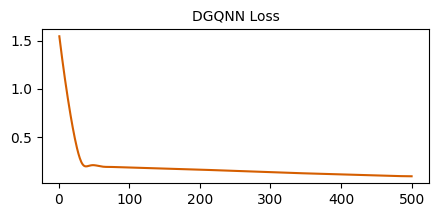

예측 관련 - Coverage Rate (CR) ⬆: 0.79, Mean Prediction Error (MPE) ⬇: 0.19
구간 관련 - Interval Width (IW) ⬇: 0.67, Sharpness ⬇: 0.46, Winkler Score (WS) ⬇: 0.69
종합 - MisCoverage Trade-off (MCT) ⬇: 0.08


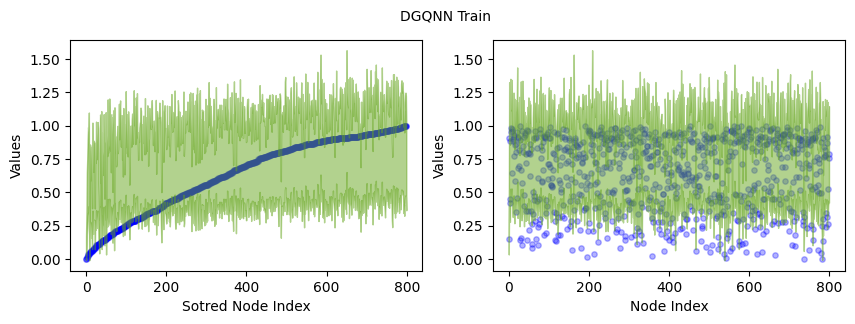

예측 관련 - Coverage Rate (CR) ⬆: 0.88, Mean Prediction Error (MPE) ⬇: 0.14
구간 관련 - Interval Width (IW) ⬇: 0.66, Sharpness ⬇: 0.45, Winkler Score (WS) ⬇: 0.67
종합 - MisCoverage Trade-off (MCT) ⬇: 0.02


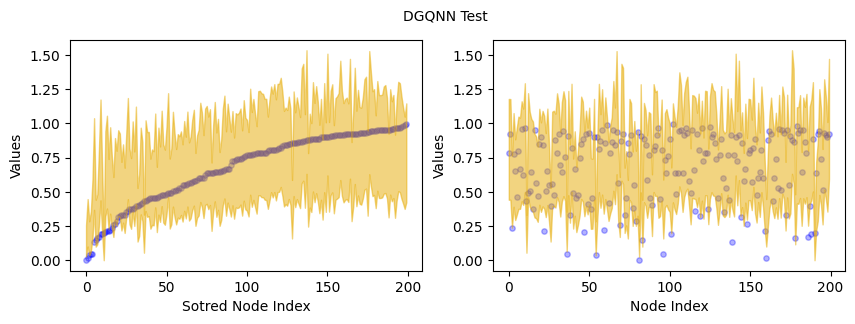

In [23]:
# DGQNN
in_dim = train_data.x.shape[1]
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
target=0.9
gamma_factor=2
lambda_factor=1
gpu_number = 0

device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)

model = GQNN_D(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
criterion = IQRLoss(target_coverage=target, gamma_factor=gamma_factor, lambda_factor=lambda_factor)

epochs = []
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    preds_low, preds_upper, taus_low, taus_upper = model(train_data.x, train_data.edge_index)
    loss = criterion(preds_low, preds_upper, taus_low, taus_upper, train_data.y)
        
    loss.backward()
    optimizer.step()
    
    epochs.append(epoch+1)
    losses.append(loss.item())
    
    cvg, wdt = coverage_width(train_data.y, preds_low, preds_upper)
    
    if epoch % (num_epochs // 5) == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.2f}, Coverage = {cvg.item():.2f}, Width = {wdt.item():.2f}")
    
plt.figure(figsize=(5, 2))
plt.plot(epochs, losses, color =color[3])
plt.title('DGQNN Loss', size=10)
plt.show()

model.eval()
test_data = test_data.to(device)

with torch.no_grad():
    preds_low, preds_upper, _, _ = model(train_data.x, train_data.edge_index)
    train_low_preds = preds_low.cpu().numpy()
    train_upper_preds = preds_upper.cpu().numpy()
    train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('Dark2')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(20, 3))  
fig.suptitle('DGQNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[4], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[4], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

with torch.no_grad():
    preds_low, preds_upper, _, _ = model(test_data.x, test_data.edge_index)
    test_low_preds = preds_low.cpu().numpy()
    test_upper_preds = preds_upper.cpu().numpy()
    test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)

x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(20, 3))  
fig.suptitle('DGQNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[5], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[5], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()